# 公司股价预测作业

# 作业要求：
设计一个预测股票价格的方法，并用实例证明此方法的有效性。  
所给的数据，要求全部都要使用，注意  
1. 数据需清洗  
2. 特征综合使用  

可自己额外补充资源或数据

# 基础得分点
1.	程序可运行
2.	缺失数据处理
3.	正则提取
4.	时间信息转换
5.	数据拼接
6.	数据标准化
7.	数据可视化
8.	模型构建与应用
9.	Markdown 排版
10.	分析逻辑

# 数据说明
1.	**全标题**   
    这是股票平台上发布的对各公司的分析文章
    1. 标题：文章的标题
    1. 字段1_链接_链接：原文章所在的URL
    1. ABOUT：文章针对的公司，都为缩写形式，多个公司以逗号隔开
    1. TIME：文章发布的时间
    1. AUTHOR：作者
    1. COMMENTS：采集时，文章的被评论次数
2.	**摘要**  
    这是股票平台上发布的对各公司的分析文章的摘要部分，**和“全标题”中的内容对应**  
    1. 标题：文章的标题  
    1. 字段2：文章发布的时间  
    1. 字段5：文章针对的公司及提及的公司；  
        1. About为针对公司，都提取缩写的大写模型，多个公司以逗号隔开  
        1. include为提及的其它公司，都提取缩写的大写模型，多个公司以逗号隔开  
    1. 字段1：摘要的全文字内容  
3.	**回帖**  
    这是网友在各文章下的回复内容   
    1. Title：各文章的标题；空标题的，用最靠近的有内容的下方标题  
    1. Content：回复的全文字内容  
4.	**论坛**  
    这是网友在各公司的论坛页面下，对之进行评论的发帖内容   
    1. 字段1：作者  
    1. 字段2：发帖日期  
    1. 字段3：帖子内容  
    1. 字段4_链接：具体的各公司的页面URL  
5.	**股票价格**
    为各公司工作日股票的价格  
    1. PERMNO：公司编号  
    1. Date：日期  
    1. TICKER：公司简写  
    1. COMNAM：公司全写  
    1. BIDLO：最低价  
    1. ASKHI：最高价  
    1. PRC：收盘价  
    1. VOL：成交量  
    1. OPENPRC：开盘价  

# 一、文件格式统一
显然，提供的文件中有`xlsx`格式的，也有`csv`格式的。  
而`csv`格式的操作行为明显速度和效率上明显优于`xlsx`格式，因此在这里我们将所有格式统一为`csv`格式。

In [1]:
import os
import pandas as pd
import numpy as np


# 转化函数，其实没有必要转化为函数，毕竟只用一次
def xlsx_to_csv_pd(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith('.xlsx')):
                # 获取文件路径
                data_xls = pd.read_excel(os.path.join(root, file), index_col=0)
                data_xls.to_csv(os.path.join(root, file).replace(
                    '.xlsx', '.csv'), encoding='utf-8')
                print(os.path.join(root, file), "转化成功")
                os.remove(os.path.join(root, file))


# 批量转化
xlsx_to_csv_pd(os.getcwd())

# 二、数据清洗

## 2.1 全标题摘要聚合
股票平台上发布的对各公司的分析文章的摘要部分，和“全标题”中的内容对应。  
所以读取全部内容，根据标题和时间以及公司聚合，同时去除原文链接这种对于我来说没用的内容。

### 2.1.1 读取全标题信息
这是股票平台上发布的对各公司的分析文章

1. 标题：文章的标题
1. 字段1_链接_链接：原文章所在的URL
1. ABOUT：文章针对的公司，都为缩写形式，多个公司以逗号隔开
1. TIME：文章发布的时间
1. AUTHOR：作者
1. COMMENTS：采集时，文章的被评论次数  

在这个Section,我们会读取整个csv文件，并且舍弃【字段1_链接_链接】

In [2]:
# 读取整个csv文件，并且舍弃【字段1_链接_链接】
Title_data = pd.read_csv("./全标题.csv", index_col=0, usecols=[0, 2, 3, 4, 5])

# 更改列标
Title_data.columns = ['针对公司', '发布时间', '作者', '评论数']

# 评论数去除Comments无用字段
Title_data["评论数"] = Title_data["评论数"].str.extract("([0-9]+)")

# 针对公司处理
Title_data["针对公司"] = Title_data["针对公司"].str.replace(" ", "")
Title_data["针对公司"] = Title_data["针对公司"].str.split(",")

# 显示内容
Title_data

,针对公司,发布时间,作者,评论数
标题,,,,
Micron Technology: Insanely Cheap Stock Given Its High Earnings Quality,[MU],"Dec. 31, 2018, 7:57 PM",Ruerd Heeg,75
Molson Coors Seems Attractive At These Valuations,[TAP],"Dec. 31, 2018, 7:44 PM",Sanjit Deepalam,16
Gerdau: The Brazilian Play On U.S. Steel,[GGB],"Dec. 31, 2018, 7:10 PM",Shannon Bruce,1
Will Apple Get Its Mojo Back?,[AAPL],"Dec. 31, 2018, 5:36 PM",TipRanks,68
Lululemon Stock Looks Compelling On This Dip,[LULU],"Dec. 31, 2018, 5:26 PM",L&F Capital Management,4
...,...,...,...,...
Overstock: The Perfect Stock Blockchain Play,[OSTK],"Jan. 1, 2018, 6:54 AM",Opaque Investors,47
2017: The Year The Unicorn Died,"[UBER, SFTBF, SFTBY]","Jan. 1, 2018, 6:54 AM",Mark St. Cyr,5
"Big Changes For Centurylink, AT&T And Verizon In 2018","[CTL, T, VZ]","Jan. 1, 2018, 5:38 AM",EconDad,32


### 2.1.2 读取摘要信息

这是股票平台上发布的对各公司的分析文章的摘要部分，**和“全标题”中的内容对应**  
1. 标题：文章的标题  
1. 字段2：文章发布的时间  
1. 字段5：文章针对的公司及提及的公司；  
    1. About为针对公司，都提取缩写的大写模型，多个公司以逗号隔开  
    1. include为提及的其它公司，都提取缩写的大写模型，多个公司以逗号隔开  
1. 字段1：摘要的全文字内容  

In [3]:
# 读取整个csv文件，并且舍弃【字段1_链接_链接】
import re
Content_data = pd.read_csv("./摘要.csv", index_col=0)

# 更改列标
Content_data.columns = ['发布时间', '针对公司', '摘要']

# 处理【时间】
Content_data["发布时间"] = Content_data["发布时间"].map(lambda x: x.replace(" ET", ""))


# 处理【针对公司】
Content_data["针对公司"] = Content_data["针对公司"].map(
    lambda x: x.split("Includes:")[0].replace("| About: ", "").split(","))
# 提取【针对公司】中的简写
Content_data["针对公司"] = Content_data["针对公司"].map(
    lambda x: ["".join(re.findall('[(](.*?)[)]', i, re.S)) for i in x if not i.find("(") == -1])

# 显示前五行内容
Content_data

,发布时间,针对公司,摘要
标题,,,
HealthEquity: Strong Growth May Be Slowing Heading Into 2021,"Apr. 1, 2019 10:46 PM",[HQY],SummaryHealthEquity’s revenue and earnings hav...
Valero May Rally Up To 40% Within The Next 12 Months,"Apr. 1, 2019 10:38 PM",[VLO],SummaryValero is ideally positioned to benefit...
Apple Makes A China Move,"Apr. 1, 2019 7:21 PM",[AAPL],SummaryCompany cuts prices on many key product...
Polaris Industries: Ready To Rally,"Apr. 1, 2019 7:14 PM",[PII],SummaryPolaris is a well-respected brand name ...
How Apple Will Return A Minimum Of 8% By The End Of FY19,"Apr. 1, 2019 5:03 PM",[AAPL],SummaryApple has exhibited strong segment grow...
...,...,...,...
Cushman & Wakefield Proposes Terms For $765 Million IPO,"Jul. 24, 2018 2:18 PM",[CWK],SummaryCushman & Wakefield has filed proposed ...
"Quantamental Focus: Home Depot A Top Buy, With Improving Operating Profitability","Jul. 24, 2018 2:16 PM",[HD],SummaryHome Depot Inc. is a specialty retailer...
Rubicon Technology: A Promising Net-Net Cash-Box Situation,"Jul. 24, 2018 2:16 PM",[RBCN],SummaryRubicon is trading well below likely li...


### 2.1.3 合并两表

In [4]:
Title_Content_data = pd.merge(
    Title_data, Content_data, right_on='标题', left_index=True, how='outer')


def UpdateCompany(x):
    try:
        x["针对公司_x"].extend(x["针对公司_y"])
        return ",".join(np.unique(x["针对公司_x"]))
    except:
        return np.NAN


def UpdateTime(x):
    try:
        return np.unique([x["发布时间_x"].strip(), x["发布时间_y"].strip()])[0]
    except:
        return np.NAN


Title_Content_data['针对公司'] = Title_Content_data[['针对公司_x', '针对公司_y']].apply(
    lambda x:  UpdateCompany(x), axis=1)

Title_Content_data['发布时间'] = Title_Content_data[["发布时间_x", "发布时间_y"]].apply(
    lambda x:  UpdateTime(x), axis=1)

# pd.to_datetime(df)

# 删除无用列
Title_Content_data.drop(["发布时间_x", "发布时间_y"], axis=1, inplace=True)
Title_Content_data.drop(["针对公司_x", "针对公司_y"], axis=1, inplace=True)

# 删除无用行
Title_Content_data.dropna(axis=0, how='any', subset=[
                          "发布时间", "针对公司", "评论数"], inplace=True)

Title_Content_data

,标题,作者,评论数,摘要,针对公司,发布时间
Micron Technology: Insanely Cheap Stock Given Its High Earnings Quality,Micron Technology: Insanely Cheap Stock Given ...,Ruerd Heeg,75,"SummaryLast year, a combination of relatively ...",MU,"Dec. 31, 2018 7:57 PM"
Molson Coors Seems Attractive At These Valuations,Molson Coors Seems Attractive At These Valuations,Sanjit Deepalam,16,SummaryMolson Coors's stock has fallen over 30...,TAP,"Dec. 31, 2018 7:44 PM"
Gerdau: The Brazilian Play On U.S. Steel,Gerdau: The Brazilian Play On U.S. Steel,Shannon Bruce,1,"SummaryGerdau is delivering good results, incl...",GGB,"Dec. 31, 2018 7:10 PM"
Will Apple Get Its Mojo Back?,Will Apple Get Its Mojo Back?,TipRanks,68,SummaryApple has been resting on a reputation ...,AAPL,"Dec. 31, 2018 5:36 PM"
Lululemon Stock Looks Compelling On This Dip,Lululemon Stock Looks Compelling On This Dip,L&F Capital Management,4,SummaryLululemon stock had a strong 2018 but f...,LULU,"Dec. 31, 2018 5:26 PM"
...,...,...,...,...,...,...
Stamps.com: A Cash Machine,Stamps.com: A Cash Machine,ChartMasterPro,1,SummaryThe Momentum Growth Quotient for the co...,STMP,"Jul. 24, 2018 1:57 PM"
Can Heineken Turn The 'Mallya Drama' In Its Own Favor?,Can Heineken Turn The 'Mallya Drama' In Its Ow...,The Millennial Investor,4,"SummaryMallya, United Breweries' chairman, can...",HEINY,"Jul. 24, 2018 1:24 PM"
Thor Industries Is Undervalued,Thor Industries Is Undervalued,Quinn Foley,22,SummaryThor and other RV makers became signifi...,THO,"Feb. 4, 2019 8:19 AM"
Xinyuan Real Estate: The Path Is Becoming Clearer,Xinyuan Real Estate: The Path Is Becoming Clearer,WG Investment Research,6,SummaryXinyuan's stock has performed well so f...,XIN,"Feb. 19, 2019 12:00 PM"


### 2.1.4 处理发布时间为标准日期格式

In [5]:
# 去除文本中空格
Title_Content_data["发布时间"] = Title_Content_data["发布时间"].str.replace(" ", "")

# 去除具体时间，只保留日期
Title_Content_data["发布时间"] = Title_Content_data["发布时间"].str.extract(
    "([a-zA-Z]+\.[0-9]+,[0-9]{4})")

# 序列转化
Title_Content_data["发布时间"] = pd.to_datetime(Title_Content_data["发布时间"])

Title_Content_data

,标题,作者,评论数,摘要,针对公司,发布时间
Micron Technology: Insanely Cheap Stock Given Its High Earnings Quality,Micron Technology: Insanely Cheap Stock Given ...,Ruerd Heeg,75,"SummaryLast year, a combination of relatively ...",MU,2018-12-31
Molson Coors Seems Attractive At These Valuations,Molson Coors Seems Attractive At These Valuations,Sanjit Deepalam,16,SummaryMolson Coors's stock has fallen over 30...,TAP,2018-12-31
Gerdau: The Brazilian Play On U.S. Steel,Gerdau: The Brazilian Play On U.S. Steel,Shannon Bruce,1,"SummaryGerdau is delivering good results, incl...",GGB,2018-12-31
Will Apple Get Its Mojo Back?,Will Apple Get Its Mojo Back?,TipRanks,68,SummaryApple has been resting on a reputation ...,AAPL,2018-12-31
Lululemon Stock Looks Compelling On This Dip,Lululemon Stock Looks Compelling On This Dip,L&F Capital Management,4,SummaryLululemon stock had a strong 2018 but f...,LULU,2018-12-31
...,...,...,...,...,...,...
Stamps.com: A Cash Machine,Stamps.com: A Cash Machine,ChartMasterPro,1,SummaryThe Momentum Growth Quotient for the co...,STMP,2018-07-24
Can Heineken Turn The 'Mallya Drama' In Its Own Favor?,Can Heineken Turn The 'Mallya Drama' In Its Ow...,The Millennial Investor,4,"SummaryMallya, United Breweries' chairman, can...",HEINY,2018-07-24
Thor Industries Is Undervalued,Thor Industries Is Undervalued,Quinn Foley,22,SummaryThor and other RV makers became signifi...,THO,2019-02-04
Xinyuan Real Estate: The Path Is Becoming Clearer,Xinyuan Real Estate: The Path Is Becoming Clearer,WG Investment Research,6,SummaryXinyuan's stock has performed well so f...,XIN,2019-02-19


## 2.2 回帖聚合
这是网友在各文章下的回复内容   
1. Title：各文章的标题；空标题的，用最靠近的有内容的下方标题  
1. Content：回复的全文字内容 

回帖都处于一个文件夹下，这时我们遍历文件夹。  
然后统一操作，合并各个Dataframe就完事了。

In [6]:
# 创建一个空的 DataFrame
Reply_data = pd.DataFrame(columns=['字段', '标题1'])

for root, dirs, files in os.walk(os.path.join(os.getcwd(), "回帖")):
    for file in files:
        if(file.endswith('.csv')):
            # 获取文件路径
            Reply_data_part = pd.read_csv(os.path.join(root, file))
            
            # 删除无用行
            Reply_data_part.dropna(axis=0, how='any', inplace=True)
            # display(Reply_data_part.head())
            Reply_data = pd.concat(
                [Reply_data, Reply_data_part], axis=0, ignore_index=True)

# 更改列标
Reply_data.columns = ['回复内容', '标题']

Reply_data.head()

,回复内容,标题
0,Bought GLW after the dot.com bust in early 200...,Corning: A Unique Company Playing In Multiple ...
1,"Bill, a very fair assessment on BB going forwa...",BlackBerry Takes A Step Forward
2,Nice article. I'm sticking with SBLKZ. Nice yield,"Star Bulk Poised To Rip Higher, Buyback Coming?"
3,Craig - Hallum was ranked on TipRanks as #1 in...,DiaMedica Therapeutics Aims For $18 Million IPO
4,Why your strong emphasis on free CF? Most d...,"Gulfport Energy: Higher Risk, Higher Reward"


## 2.3 论坛聚合
这是网友在各公司的论坛页面下，对之进行评论的发帖内容   
1. 字段1：作者  
1. 字段2：发帖日期  
1. 字段3：帖子内容  
1. 字段4_链接：具体的各公司的页面URL  

In [7]:
# 创建一个空的 DataFrame
Forum_data = pd.read_csv("论坛.csv")

# 更改列标
Forum_data.columns = ['作者', '发帖日期', '帖子内容', '公司']

# 删除无用行
Forum_data.dropna(axis=0, how='any', inplace=True)

Forum_data.head()

,作者,发帖日期,帖子内容,公司
0,ComputerBlue,31-Dec-18,Let's create a small spec POS portfolio $COTY ...,https://seekingalpha.com/symbol/COTY
1,Darren McCammon,31-Dec-18,"$RICK ""Now that we've reported results, we'll ...",https://seekingalpha.com/symbol/RICK
2,Jonathan Cooper,31-Dec-18,Do any $APHA shareholders support the $GGB tak...,https://seekingalpha.com/symbol/APHA
3,lstasel,31-Dec-18,Long on $T . Even if it means smaller dividend...,https://seekingalpha.com/symbol/T
4,Nicholas Ward,31-Dec-18,"2018 was a down year for me, but I'm happy to ...",https://seekingalpha.com/symbol/SPY


### 2.3.1 公司序列处理
可以看到公司那一栏其实是URL，前面的 https://seekingalpha.com/symbol/ 可以直接去掉

In [8]:
Forum_data["公司"] = Forum_data["公司"].str.replace(
    r"https://seekingalpha.com/symbol/", "")

Forum_data.head()

,作者,发帖日期,帖子内容,公司
0,ComputerBlue,31-Dec-18,Let's create a small spec POS portfolio $COTY ...,COTY
1,Darren McCammon,31-Dec-18,"$RICK ""Now that we've reported results, we'll ...",RICK
2,Jonathan Cooper,31-Dec-18,Do any $APHA shareholders support the $GGB tak...,APHA
3,lstasel,31-Dec-18,Long on $T . Even if it means smaller dividend...,T
4,Nicholas Ward,31-Dec-18,"2018 was a down year for me, but I'm happy to ...",SPY


然后时间那里一样需要格式化成一样的

In [9]:
Forum_data["发帖日期"] = pd.to_datetime(Forum_data["发帖日期"])

Forum_data.head()

,作者,发帖日期,帖子内容,公司
0,ComputerBlue,2018-12-31,Let's create a small spec POS portfolio $COTY ...,COTY
1,Darren McCammon,2018-12-31,"$RICK ""Now that we've reported results, we'll ...",RICK
2,Jonathan Cooper,2018-12-31,Do any $APHA shareholders support the $GGB tak...,APHA
3,lstasel,2018-12-31,Long on $T . Even if it means smaller dividend...,T
4,Nicholas Ward,2018-12-31,"2018 was a down year for me, but I'm happy to ...",SPY


## 2.4 股价处理
为各公司工作日股票的价格  
1. PERMNO：公司编号  
1. Date：日期  
1. TICKER：公司简写  
1. COMNAM：公司全写  
1. BIDLO：最低价  
1. ASKHI：最高价  
1. PRC：收盘价  
1. VOL：成交量  
1. OPENPRC：开盘价 

In [10]:
# 创建一个空的 DataFrame
Stock_data = pd.read_csv("股票价格.csv", usecols=[0, 1, 2, 4, 5, 6, 7, 8])

# 更改列标
Stock_data.columns = ['公司编号', '日期', '公司简写', '最低价', '最高价', '收盘价', '成交量', '开盘价']


# 删除无用行
Stock_data.dropna(axis=0, how='any', inplace=True)

Stock_data.head()

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价
0,10026,20180702,JJSF,150.70000,153.27499,152.92000,100388.0,152.17999
1,10026,20180703,JJSF,151.35001,153.73000,153.32001,55547.0,153.67000
2,10026,20180705,JJSF,152.46001,156.00000,155.81000,199370.0,153.95000
3,10026,20180706,JJSF,154.80000,158.44000,158.42999,127431.0,156.00000
4,10026,20180709,JJSF,154.44000,159.05000,154.53000,97661.0,158.60001


时间序列处理一下

In [11]:
Stock_data["日期"] = pd.to_datetime(Stock_data["日期"], format="%Y%m%d")
Stock_data.head()

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价
0,10026,2018-07-02,JJSF,150.70000,153.27499,152.92000,100388.0,152.17999
1,10026,2018-07-03,JJSF,151.35001,153.73000,153.32001,55547.0,153.67000
2,10026,2018-07-05,JJSF,152.46001,156.00000,155.81000,199370.0,153.95000
3,10026,2018-07-06,JJSF,154.80000,158.44000,158.42999,127431.0,156.00000
4,10026,2018-07-09,JJSF,154.44000,159.05000,154.53000,97661.0,158.60001


# 三、图表绘制

## 3.1 各公司股票分类
按照各个公司将股票分开，这里利用groupby函数。  
这里只展示分类后第一个股票的图表。

In [12]:
import matplotlib.pyplot as plt

StockData = Stock_data.groupby(['公司编号'])

现在我们其中一个公司，因为其实对于不同公司来说，股价的预测可能是不一样的。  
而且，数据量太大，运行起来太慢。

In [13]:
Company_test = Stock_data[Stock_data["公司简写"] == "MU"]

Company_test

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价
500578,53613,2018-07-02,MU,51.32,54.5300,54.48,38915998.0,51.52
500579,53613,2018-07-03,MU,50.10,54.7900,51.48,52179035.0,54.55
500580,53613,2018-07-05,MU,51.94,53.3100,52.84,51116248.0,52.85
500581,53613,2018-07-06,MU,51.98,53.4100,53.23,31831420.0,52.54
500582,53613,2018-07-09,MU,53.11,54.5000,54.31,32561338.0,53.80
...,...,...,...,...,...,...,...,...
500699,53613,2018-12-24,MU,29.00,30.3500,29.02,23995373.0,29.86
500700,53613,2018-12-26,MU,28.39,30.9100,30.89,45697474.0,29.34
500701,53613,2018-12-27,MU,30.23,32.0100,31.93,39864916.0,30.41
500702,53613,2018-12-28,MU,31.40,32.2785,31.57,29849028.0,32.00


### 3.1.1 成交量绘图
这里我们绘制MU公司的成交量折线图。

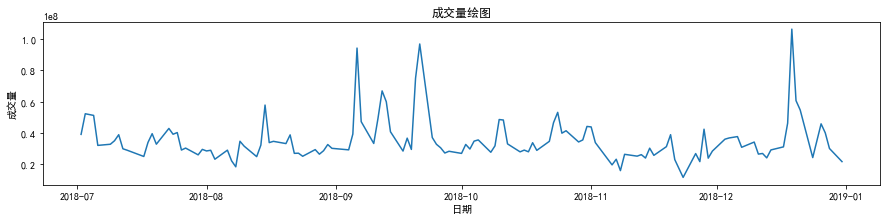

In [14]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"], Company_test["成交量"])
plt.title("成交量绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("成交量")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 3.1.2 收盘价绘图
这里我们绘制MU公司的收盘价折线图。

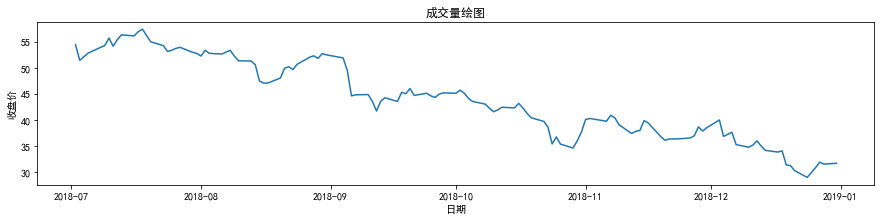

In [15]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"], Company_test["收盘价"])
plt.title("成交量绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("收盘价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 3.1.3 收盘价*成交量绘图

# 四、有效数据整合

在最终的的数据里，已经最后用于分析的模型中，我们将会用到`帖子评论数`和`论坛评论数`来进行最终结果的预测。  
所以在这里，我们新增两行来存贮这些数据。

In [16]:
Stock_data['帖子评论数'] = 0
Stock_data['论坛评论数'] = 0
Stock_data.head()

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价,帖子评论数,论坛评论数
0,10026,2018-07-02,JJSF,150.70000,153.27499,152.92000,100388.0,152.17999,0,0
1,10026,2018-07-03,JJSF,151.35001,153.73000,153.32001,55547.0,153.67000,0,0
2,10026,2018-07-05,JJSF,152.46001,156.00000,155.81000,199370.0,153.95000,0,0
3,10026,2018-07-06,JJSF,154.80000,158.44000,158.42999,127431.0,156.00000,0,0
4,10026,2018-07-09,JJSF,154.44000,159.05000,154.53000,97661.0,158.60001,0,0


每个公司对应帖子的评论数和论坛的评论数整合。  
这里只对一家公司做测试，因为数据集太大了。

In [17]:
Company_test = Stock_data[Stock_data["公司简写"] == "MU"]

# 按照时间排序
Company_test = Company_test.sort_values(by='日期')

Company_test

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价,帖子评论数,论坛评论数
500578,53613,2018-07-02,MU,51.32,54.5300,54.48,38915998.0,51.52,0,0
500579,53613,2018-07-03,MU,50.10,54.7900,51.48,52179035.0,54.55,0,0
500580,53613,2018-07-05,MU,51.94,53.3100,52.84,51116248.0,52.85,0,0
500581,53613,2018-07-06,MU,51.98,53.4100,53.23,31831420.0,52.54,0,0
500582,53613,2018-07-09,MU,53.11,54.5000,54.31,32561338.0,53.80,0,0
...,...,...,...,...,...,...,...,...,...,...
500699,53613,2018-12-24,MU,29.00,30.3500,29.02,23995373.0,29.86,0,0
500700,53613,2018-12-26,MU,28.39,30.9100,30.89,45697474.0,29.34,0,0
500701,53613,2018-12-27,MU,30.23,32.0100,31.93,39864916.0,30.41,0,0
500702,53613,2018-12-28,MU,31.40,32.2785,31.57,29849028.0,32.00,0,0


现在找出所有对应的帖子。  
此处的对应指的是公司和发布时间相对应。

In [18]:
MU_Passage = Title_Content_data[Title_Content_data["针对公司"].str.contains("MU")]

MU_Passage

,标题,作者,评论数,摘要,针对公司,发布时间
Micron Technology: Insanely Cheap Stock Given Its High Earnings Quality,Micron Technology: Insanely Cheap Stock Given ...,Ruerd Heeg,75,"SummaryLast year, a combination of relatively ...",MU,2018-12-31
"Micron Earnings Review: Free Cash Flow Yield Is 24%, Capital Discipline Is At Hand",Micron Earnings Review: Free Cash Flow Yield I...,"Brian Gilmartin, CFA",72,SummaryEPS estimates have fallen sharply after...,MU,2018-12-30
Micron's Trajectory After The Q1 2019 Earnings Release,Micron's Trajectory After The Q1 2019 Earnings...,Jeffery Margolf,27,SummaryMicron collapsed in the second half of ...,MU,2018-12-27
Micron: A Major Opportunity Trading At Book Value,Micron: A Major Opportunity Trading At Book Value,Lyn Alden Schwartzer,205,SummaryMicron Technology is now trading just a...,MU,2018-12-27
Micron: This Ain't 2016,Micron: This Ain't 2016,Billy Duberstein,118,SummaryIt looks as if Micron is undergoing its...,MU,2018-12-26
...,...,...,...,...,...,...
Murphy Oil Falls Despite Strong Q2 Results,Murphy Oil Falls Despite Strong Q2 Results,Leo Nelissen,8,SummaryMurphy Oil beat both sales and EPS esti...,MUR,2018-08-10
Micron: Sky-High Price Targets Justified?,Micron: Sky-High Price Targets Justified?,Khaveen Jeyaratnam,267,SummaryMicron’s price targets have been held a...,MU,2018-08-09
Micron: A Bad Beat Perspective,Micron: A Bad Beat Perspective,Quad 7 Capital,364,SummaryWe recently made a short-term trade in ...,MU,2018-08-02
Micron: Among The Best Bargains In Memory,Micron: Among The Best Bargains In Memory,Russell Naisbitt,311,"SummaryCurrently mired in the low $50’s, Micro...",MU,2018-07-31


找出所有对应帖子后，我们增加相应的评论数。  
下面是我们操作完毕的结果。

In [19]:
def AddCount(r):
    row = MU_Passage.loc[(MU_Passage["针对公司"] == r["公司简写"])
                         & (MU_Passage["发布时间"] == r["日期"])]
    count = int(r["帖子评论数"])
    for rr in row.itertuples():
        count += int(getattr(rr, '评论数'))
    return count


Company_test["帖子评论数"] = Company_test[['帖子评论数', '公司简写', '日期']].apply(
    lambda x: AddCount(x), axis=1)

Company_test

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价,帖子评论数,论坛评论数
500578,53613,2018-07-02,MU,51.32,54.5300,54.48,38915998.0,51.52,0,0
500579,53613,2018-07-03,MU,50.10,54.7900,51.48,52179035.0,54.55,0,0
500580,53613,2018-07-05,MU,51.94,53.3100,52.84,51116248.0,52.85,0,0
500581,53613,2018-07-06,MU,51.98,53.4100,53.23,31831420.0,52.54,0,0
500582,53613,2018-07-09,MU,53.11,54.5000,54.31,32561338.0,53.80,0,0
...,...,...,...,...,...,...,...,...,...,...
500699,53613,2018-12-24,MU,29.00,30.3500,29.02,23995373.0,29.86,0,0
500700,53613,2018-12-26,MU,28.39,30.9100,30.89,45697474.0,29.34,118,0
500701,53613,2018-12-27,MU,30.23,32.0100,31.93,39864916.0,30.41,232,0
500702,53613,2018-12-28,MU,31.40,32.2785,31.57,29849028.0,32.00,0,0


接下来处理论坛评论，操作方法和上面一致。

In [20]:
MU_Forum = Forum_data[Forum_data["公司"] == "MU"]

MU_Forum

,作者,发帖日期,帖子内容,公司
53,Sunil Shah,2018-12-30,$MU The latter proposals include cracking down...,MU
117,Sunil Shah,2018-12-28,$MUCheck the OBV min by min for last 3 days.Th...,MU
124,Sunil Shah,2018-12-28,$MU last chance to get on board before MASSIVE...,MU
225,Sunil Shah,2018-12-26,$MU Did I say 24 dec was the low.WELL it's tod...,MU
330,Sunil Shah,2018-12-24,$MU @RogerSach @floridahockey @Natecrk6 @Ian C...,MU
...,...,...,...,...
24323,Vertical Spread,2018-01-09,"Back into 2018 Long term Call Spreads, $MU, $N...",MU
24391,GarethSoloway,2018-01-09,Sold $MU scalp at $43.88 from entry of $43.57 ...,MU
24394,GarethSoloway,2018-01-09,$MU hitting major support here at $43.50. Gap ...,MU
24533,Ryan Mallory,2018-01-08,Stocks to Trade: $MU $PAH-OLD $MAR http://bit....,MU


In [21]:
def AddCount_n(r):
    row = MU_Forum.loc[(MU_Forum["公司"] == r["公司简写"]) &
                       (MU_Forum["发帖日期"] == r["日期"])]
    count = int(r["论坛评论数"])
    for rr in row.itertuples():
        count += 1
    return count


Company_test["论坛评论数"] = Company_test[['论坛评论数', '公司简写', '日期']].apply(
    lambda x: AddCount_n(x), axis=1)

Company_test

,公司编号,日期,公司简写,最低价,最高价,收盘价,成交量,开盘价,帖子评论数,论坛评论数
500578,53613,2018-07-02,MU,51.32,54.5300,54.48,38915998.0,51.52,0,1
500579,53613,2018-07-03,MU,50.10,54.7900,51.48,52179035.0,54.55,0,2
500580,53613,2018-07-05,MU,51.94,53.3100,52.84,51116248.0,52.85,0,2
500581,53613,2018-07-06,MU,51.98,53.4100,53.23,31831420.0,52.54,0,1
500582,53613,2018-07-09,MU,53.11,54.5000,54.31,32561338.0,53.80,0,0
...,...,...,...,...,...,...,...,...,...,...
500699,53613,2018-12-24,MU,29.00,30.3500,29.02,23995373.0,29.86,0,1
500700,53613,2018-12-26,MU,28.39,30.9100,30.89,45697474.0,29.34,118,1
500701,53613,2018-12-27,MU,30.23,32.0100,31.93,39864916.0,30.41,232,0
500702,53613,2018-12-28,MU,31.40,32.2785,31.57,29849028.0,32.00,0,2


# 五、线性回归

## 5.1 导入模块

In [22]:
from sklearn import datasets
from sklearn.linear_model import ElasticNet

## 5.2 弹性网络回归模型

### 5.2.1 训练集处理

In [23]:
# 测试集采样率
RATING = 0.3

# 集合创建
test = pd.DataFrame()              # 划分出的test集合
train = pd.DataFrame()             # 剩余的train集合

# 训练样本
sample = Company_test.sample(int(RATING*len(Company_test)))
sample_index = sample.index

# 剩余数据
all_index = Company_test.index
residue_index = all_index.difference(sample_index)  # 去除sample之后剩余的数据
residue = Company_test.loc[residue_index]  # 这里要使用.loc而非.iloc

# 保存
test = pd.concat([test, sample], ignore_index=True)
train = pd.concat([train, residue], ignore_index=True)


# 只保留训练数据
test = pd.DataFrame(
    test, columns=['最低价', '最高价', '收盘价', '成交量', '开盘价', "帖子评论数", "论坛评论数"])
train = pd.DataFrame(
    train, columns=['最低价', '最高价', '收盘价', '成交量', '开盘价', "帖子评论数", "论坛评论数"])

在这里我们还需要将所有的数据上下两行相减。  
在我看来，下一天的股价必然和前一天的股价有关，同%gui又与人们的评论数目有关。  
至于为什么不做情感分析？  
因为有评论总比没评论要好，评论有就说明人们持续关注，而一个股票最重要的就是热度

In [24]:
test_n=pd.DataFrame()
test_n[['最低价', '最高价', '收盘价', '成交量', '开盘价']] = test[[
    '最低价', '最高价', '收盘价', '成交量', '开盘价']].shift(1)
test[['最低价', '最高价', '收盘价', '成交量', '开盘价']
     ] -= test_n[['最低价', '最高价', '收盘价', '成交量', '开盘价']]

# 删除无用行
test.dropna(axis=0, how='any', inplace=True)

In [25]:
train_n=pd.DataFrame()
train_n[['最低价', '最高价', '收盘价', '成交量', '开盘价']] = train[[
    '最低价', '最高价', '收盘价', '成交量', '开盘价']].shift(1)
train[['最低价', '最高价', '收盘价', '成交量', '开盘价']
      ] -= train_n[['最低价', '最高价', '收盘价', '成交量', '开盘价']]

# 删除无用行
train.dropna(axis=0, how='any', inplace=True)

后期进行模型的拟合，需要用到Numpy中的矩阵。  
所以在这里提前转化为矩阵。

In [26]:
# 转化为numpy中的矩阵
test = np.array(test)
train = np.array(train)

### 5.2.2 模型创建
这里采用的是弹性网络模型。  
然后训练的数据其实是用前一天的数据去预测后一天的数据。

In [27]:
# 建立模型
model = ElasticNet()
# 开始训练
model.fit(train[:-2], train[1:-1, :5])

ElasticNet()

In [28]:
# 测试
#result = np.vstack((test,train))
predict = model.predict(test)
print('predict:')
display(pd.DataFrame(predict))
print('test:')
display(pd.DataFrame(test))

predict:


,0,1,2,3,4
0,-0.324136,-0.551394,0.094431,-1.418783e+06,-2.995172
1,-0.370969,-0.638064,-0.208426,-6.679494e+06,-1.835660
2,0.589649,0.895876,0.015339,7.016144e+06,4.607448
3,-1.037168,-0.928800,-1.104351,-4.080368e+06,-1.081436
4,-0.467017,-0.783392,-0.033196,1.685619e+06,-3.477304
5,-0.191386,-0.347014,-0.061288,6.104036e+05,-1.162693
6,0.620309,0.942816,-0.027094,6.986268e+06,5.063323
7,-0.590589,-0.976951,0.030440,-8.633691e+05,-4.772629
8,-0.205835,-0.199933,-0.556878,-6.374661e+06,1.576247
9,-0.377176,-0.255359,-0.409995,3.085284e+05,-0.126906


test:


,0,1,2,3,4,5,6
0,-9.6900,-10.3700,-10.32,-12666639.0,-9.350,0.0,0.0
1,-6.8100,-5.8100,-5.35,16607118.0,-6.700,0.0,1.0
2,17.1400,17.3600,15.45,-5021706.0,18.420,0.0,0.0
3,-2.2254,-3.1000,-1.24,-10037380.0,-2.865,473.0,1.0
4,-10.4446,-10.3150,-11.48,-330409.0,-10.465,0.0,3.0
5,-3.6000,-2.6650,-3.62,2384959.0,-2.470,0.0,2.0
6,16.4400,15.3100,17.13,-920211.0,15.260,0.0,0.0
7,-15.3800,-15.9200,-16.05,-6481339.0,-16.160,0.0,2.0
8,6.9200,7.7500,6.95,23473524.0,6.840,112.0,0.0
9,0.3600,-0.3800,0.29,-20411504.0,0.300,236.0,0.0


下面这个是余弦相似度函数，用来判断两个预测结果的相似度的。

In [29]:
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)[:, :5]
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

这里是预测率

In [30]:
num = 0
for i in range(len(test)-1):
    # print(cos_sim(predict[i],test[i]))
    if cos_sim(predict[i], test[i+1]) > 0.99:
        num += 1

print("预测率：%s" % (num/len(test)))

预测率：0.6111111111111112


# 六、绘图

In [31]:
result = np.mat(model.predict(np.vstack((test, train))))

# 将结果转化为DataFrame
pd.DataFrame(result)

,0,1,2,3,4
0,-0.324136,-0.551394,0.094431,-1.418783e+06,-2.995172
1,-0.370969,-0.638064,-0.208426,-6.679494e+06,-1.835660
2,0.589649,0.895876,0.015339,7.016144e+06,4.607448
3,-1.037168,-0.928800,-1.104351,-4.080368e+06,-1.081436
4,-0.467017,-0.783392,-0.033196,1.685619e+06,-3.477304
...,...,...,...,...,...
119,0.173122,0.248016,0.342327,8.724753e+06,-0.326562
120,-0.396982,-0.493019,-0.553413,-7.326299e+06,0.070758
121,-0.457023,-0.394633,-0.550916,-2.196870e+06,-0.057571
122,0.031478,0.011970,0.067007,8.028502e+06,-0.053436


In [32]:
Company_test_temp = pd.DataFrame()
Company_test_temp[['最低价', '最高价', '收盘价', '成交量', '开盘价']
                  ] = Company_test[['最低价', '最高价', '收盘价', '成交量', '开盘价']].shift(1)
Company_test_temp[['最低价', '最高价', '收盘价', '成交量', '开盘价']
                  ] -= Company_test[['最低价', '最高价', '收盘价', '成交量', '开盘价']]

Company_test_temp.dropna(axis=0, how='any', inplace=True)

Company_test_temp

,最低价,最高价,收盘价,成交量,开盘价
500579,1.22,-0.2600,3.00,-13263037.0,-3.03
500580,-1.84,1.4800,-1.36,1062787.0,1.70
500581,-0.04,-0.1000,-0.39,19284828.0,0.31
500582,-1.13,-1.0900,-1.08,-729918.0,-1.26
500583,-1.24,-1.4000,-1.43,-2273157.0,-0.86
...,...,...,...,...,...
500699,1.11,1.7000,1.30,30627935.0,1.82
500700,0.61,-0.5600,-1.87,-21702101.0,0.52
500701,-1.84,-1.1000,-1.04,5832558.0,-1.07
500702,-1.17,-0.2685,0.36,10015888.0,-1.59


## 6.1最低价走势比较

### 6.1.1 原始数据

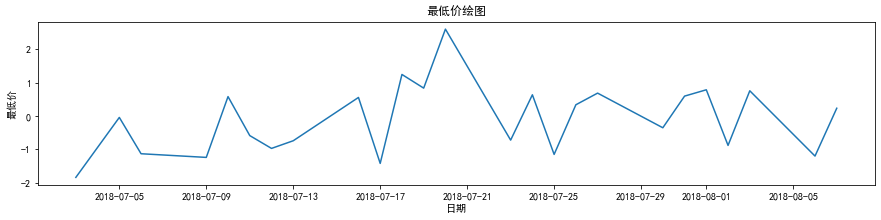

In [33]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"].iloc[1:26], Company_test_temp["最低价"].iloc[1:26])
plt.title("最低价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("最低价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 6.1.2 预测数据

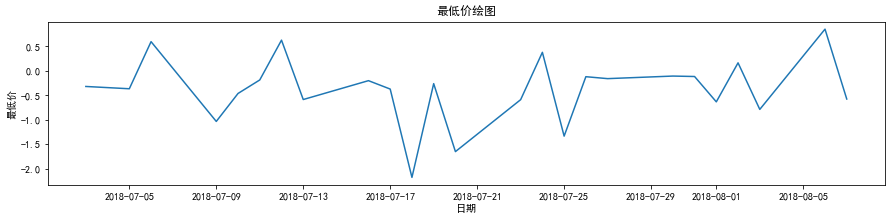

In [34]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

# print(np.array(s[0]))
plt.plot(Company_test["日期"][1:26], result[:25, 0])
plt.title("最低价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("最低价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

## 6.2最高价走势比较

### 6.2.1 原始数据

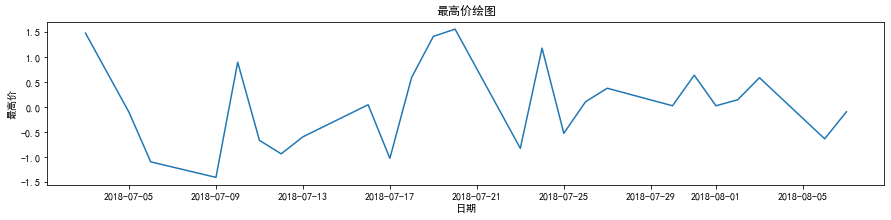

In [35]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"].iloc[1:26], Company_test_temp["最高价"].iloc[1:26])
plt.title("最高价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("最高价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 6.2.2 预测数据

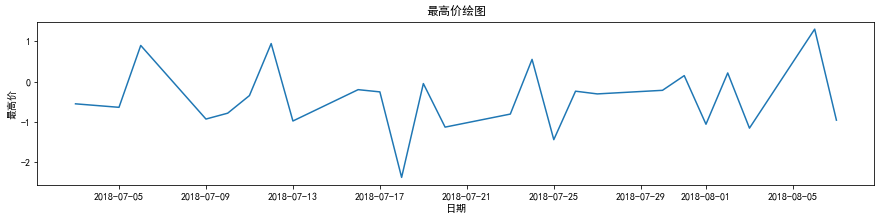

In [36]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

# print(np.array(s[0]))
plt.plot(Company_test["日期"][1:26], result[:25, 1])
plt.title("最高价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("最高价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

## 6.3收盘价走势比较

### 6.3.1 原始数据

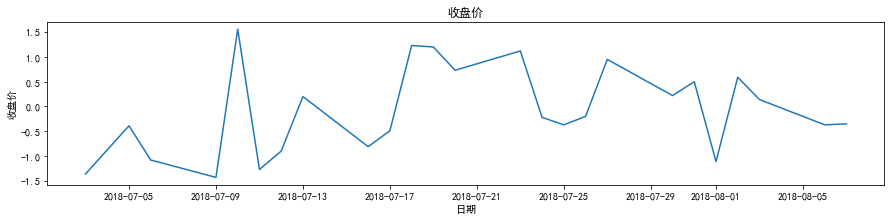

In [37]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"].iloc[1:26], Company_test_temp["收盘价"].iloc[1:26])
plt.title("收盘价")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("收盘价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 6.3.2 预测数据

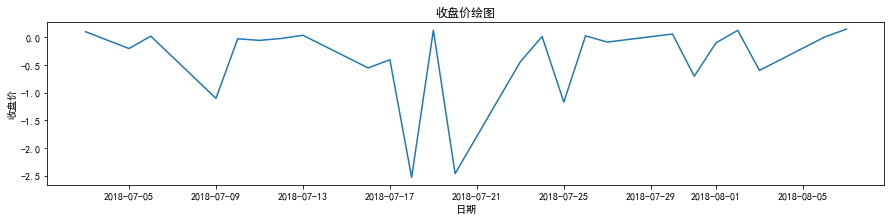

In [38]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

# print(np.array(s[0]))
plt.plot(Company_test["日期"][1:26], result[:25, 2])
plt.title("收盘价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("收盘价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

## 6.4成交量走势预测

### 6.4.1 原始数据

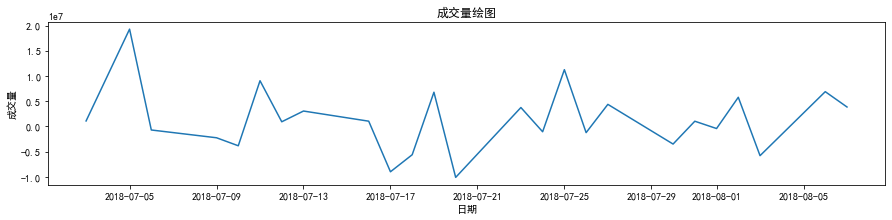

In [39]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"].iloc[1:26], Company_test_temp["成交量"].iloc[1:26])
plt.title("成交量绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("成交量")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 6.4.2 预测数据

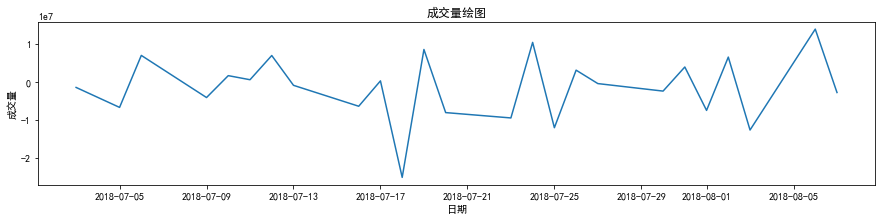

In [40]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

# print(np.array(s[0]))
plt.plot(Company_test["日期"][1:26], result[:25, 3])
plt.title("成交量绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("成交量")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

## 6.5 开盘价走势预测

### 6.3.1 原始数据

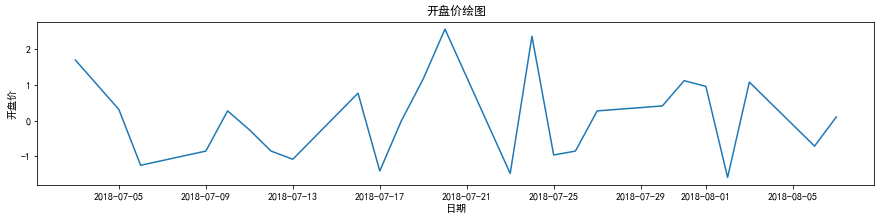

In [41]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

plt.plot(Company_test["日期"].iloc[1:26], Company_test_temp["开盘价"].iloc[1:26])
plt.title("开盘价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("开盘价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()

### 6.5.2 预测数据

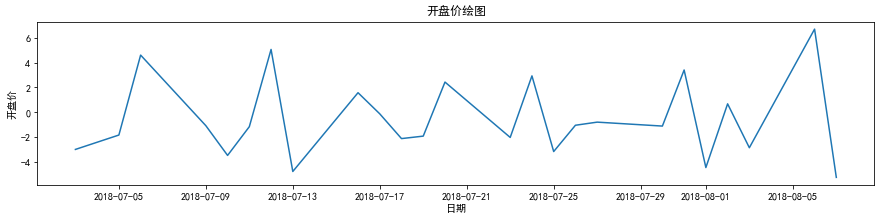

In [42]:
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

plt.figure(figsize=(15, 3))

# print(np.array(s[0]))
plt.plot(Company_test["日期"][1:26], result[:25, 4])
plt.title("开盘价绘图")  # 图名
plt.xlabel("日期")  # x轴标签
plt.ylabel("开盘价")  # y轴标签
plt.tick_params(axis='both')  # x,y轴都有刻度
plt.show()